In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pandas as pd
import numpy as np
import time

In [3]:
def preprocess_data(data_path):
    data = pd.read_csv(data_path)
    data['label'] = data['Suicide'].map({'suicide': 1, 'non-suicide': 0})
    data = data.dropna(subset=['Tweet', 'label'])
    # Enhanced preprocessing
    data['Tweet'] = data['Tweet'].str.lower()
    data['Tweet'] = data['Tweet'].str.replace(r'http\S+|www.\S+', '', regex=True)  # Remove URLs
    data['Tweet'] = data['Tweet'].str.replace(r'@\w+', '@user', regex=True)  # Standardize mentions
    data['Tweet'] = data['Tweet'].str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
    return data

In [4]:
# Dataset class with proper padding
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, MAX_LENGTH = 512):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_length = MAX_LENGTH
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts.iloc[idx])
        indices = [self.vocab[token] for token in tokens]

        # Padding/truncating
        if len(indices) < self.max_length:
            indices = indices + [self.vocab['<pad>']] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels.iloc[idx], dtype=torch.long)

In [5]:
# Enhanced model with LSTM
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=1)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [6]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [7]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer,
                device, num_epochs=25, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    train_acc_hist = []
    train_loss_hist = []
    val_loss_hist = []
    val_acc_hist = []
    for epoch in range(num_epochs):
        # Training
        start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_dataloader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_dataloader)
        train_acc = correct / total

        # Validation
        val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
        # Calculate time elapsed
        epoch_time = time.time() - start_time

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'Time Elapsed: {epoch_time:.2f} seconds')
        train_acc_hist.append(train_acc)
        train_loss_hist.append(train_loss)
        val_acc_hist.append(val_acc)
        val_loss_hist.append(val_loss)
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                return epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist
                break
    return epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist


In [8]:
EMBED_DIM = 256
HIDDEN_DIM = 128
BATCH_SIZE = 512
LEARNING_RATE = 1e-4
MAX_LENGTH = 512

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
data = preprocess_data('/kaggle/input/Suicide_Detection.csv')
data.head()

,Tweet,Suicide,label
0,ex wife threatening suiciderecently i left my ...,suicide,1
1,am i weird i dont get affected by compliments ...,non-suicide,0
2,finally 2020 is almost over so i can never hea...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,im so losthello my name is adam 16 and ive bee...,suicide,1


In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
        data['Tweet'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
    )

In [12]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(
        map(tokenizer, train_texts),
        specials=['<unk>', '<pad>'],
        min_freq=2)
vocab.set_default_index(vocab['<unk>'])

In [13]:
train_dataset = TextDataset(train_texts, train_labels, vocab, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, vocab, tokenizer)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [15]:
model = TextClassificationModel(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=2
).to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Train model
epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device)

Epoch 1/25:
Train Loss: 0.4447 | Train Acc: 0.7872
Val Loss: 0.3036 | Val Acc: 0.8807
Time Elapsed: 238.58 seconds
Epoch 2/25:
Train Loss: 0.2689 | Train Acc: 0.8973
Val Loss: 0.2434 | Val Acc: 0.9098
Time Elapsed: 238.36 seconds
Epoch 3/25:
Train Loss: 0.2234 | Train Acc: 0.9152
Val Loss: 0.2236 | Val Acc: 0.9194
Time Elapsed: 237.05 seconds
Epoch 4/25:
Train Loss: 0.2007 | Train Acc: 0.9252
Val Loss: 0.2074 | Val Acc: 0.9261
Time Elapsed: 237.45 seconds
Epoch 5/25:
Train Loss: 0.1838 | Train Acc: 0.9317
Val Loss: 0.1924 | Val Acc: 0.9315
Time Elapsed: 236.83 seconds
Epoch 6/25:
Train Loss: 0.1680 | Train Acc: 0.9377
Val Loss: 0.1831 | Val Acc: 0.9352
Time Elapsed: 236.91 seconds
Epoch 7/25:
Train Loss: 0.1605 | Train Acc: 0.9412
Val Loss: 0.1786 | Val Acc: 0.9372
Time Elapsed: 237.29 seconds
Epoch 8/25:
Train Loss: 0.1471 | Train Acc: 0.9458
Val Loss: 0.1676 | Val Acc: 0.9410
Time Elapsed: 237.29 seconds
Epoch 9/25:
Train Loss: 0.1376 | Train Acc: 0.9497
Val Loss: 0.1624 | Val Acc: 0

In [23]:
epochs = range(1, len(train_loss_hist) + 1)

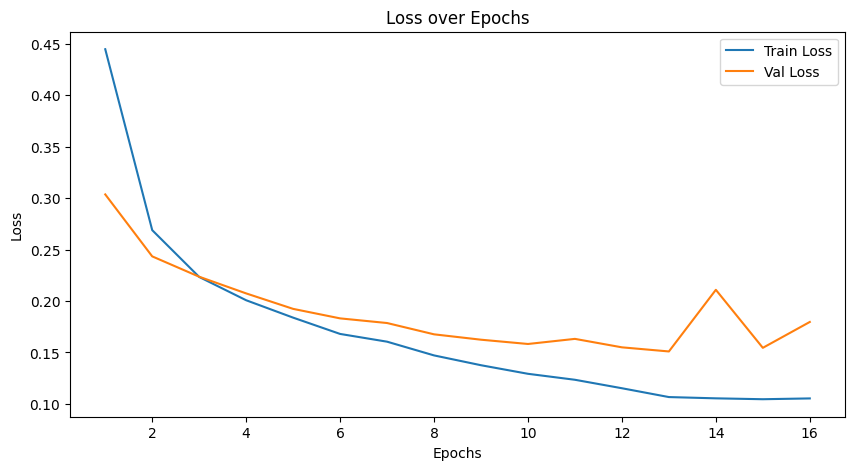

In [24]:
# Loss Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

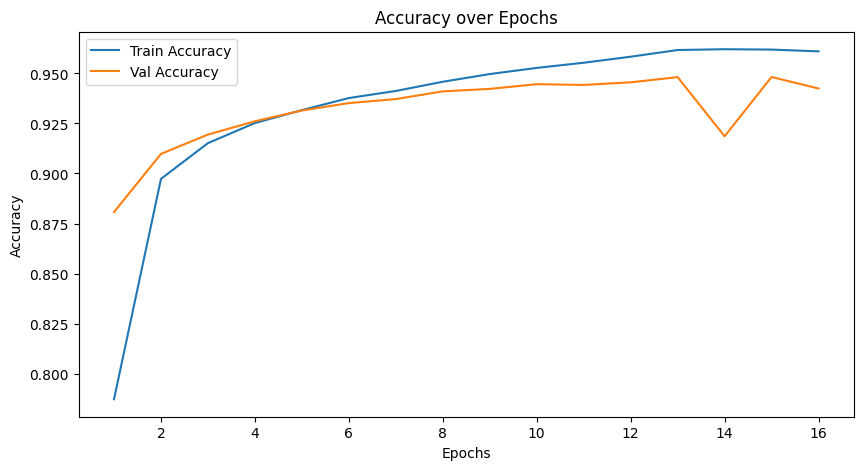

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_hist, label='Train Accuracy')
plt.plot(epochs, val_acc_hist, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()